# Binary classification

Recall from our EDA, our plot of the length and angle_from_snout features:


<AxesSubplot:xlabel='length', ylabel='angle_from_snout'>

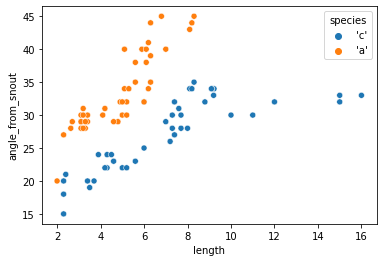

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import pseudo data set
df = pd.read_csv('../../data/tabular/croc-aligator.csv')
training_data = pd.DataFrame({'length': df.length, 'angle_from_snout': df.angle_from_snout}).to_numpy()

# Map crocs, alligators to (-1,1) for classification
labels =  pd.factorize(df.species)
vfunc = np.vectorize(lambda t: -1 if t == 0 else 1)
labels = vfunc(labels[0])

#Visualize the data
sns.scatterplot(data=df, x="length", y='angle_from_snout', hue='species', legend='full')



## Choosing a model

Given our two features, how can we come up with a function $f$ that allows us to distinguish between crocs and alligators? Formally we want:
$f: \mathbb{R}^2 \rightarrow \{\text{alligator},\text{crocodile}\}$.

Well, if we look at the figure above, it seems like almost all points in that space can be separated by a line. This seems like a reasonable thing to do,
if we were to draw a line in between the orange and blue points, we could claim that any point that falls above the line is an alligator and any point
that falls below the line is a crocodile.

Let us proceed with this discriminative line of reasoning.  So our task now is to come up with an equation for a line. Let us visualize what this line might look like.
By visual inspection it looks like we have a slope of 1.5 and an intercept of 21


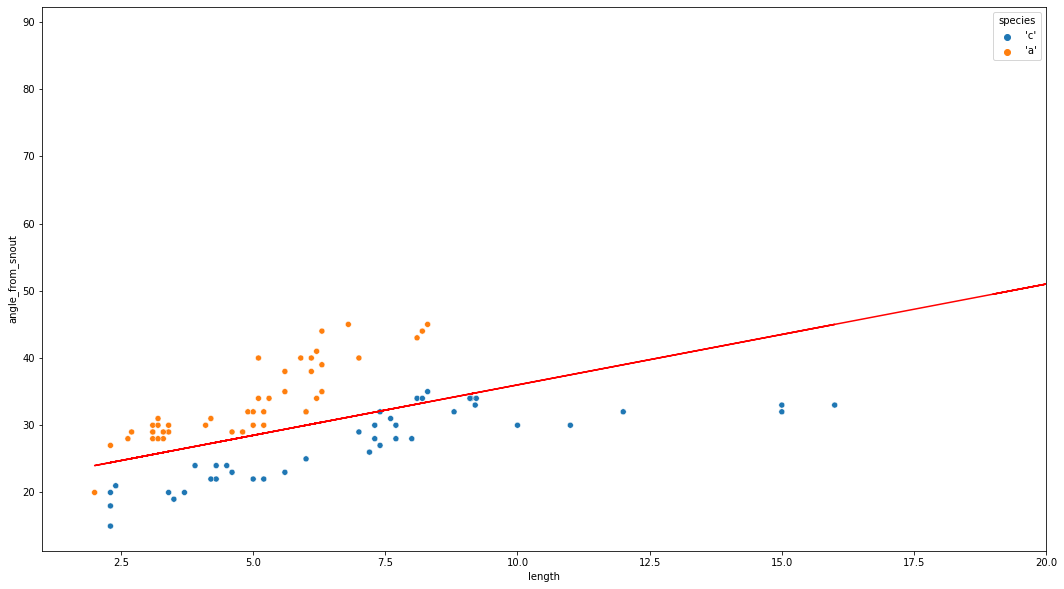

In [31]:
def eq_of_line(x) -> int:
    return 1.5*x + 21
model_prediction = [eq_of_line(d) for d in training_data]

fig, ax = plt.subplots(figsize=(18,10))
scatter = sns.scatterplot(data=df, x="length", y='angle_from_snout', hue='species', legend='full', ax=ax)
ax.set_xlim(1, 20)
scatter.plot(training_data, model_prediction, color='r',  )


### Linear Algebra

#### Perpendicular vectors

Okay, so we've come up with a line, but our task isn't quite complete, we still don't have an $f$ that classifies our data.
What we need is to somehow use our line to classify a point in feature space. The answer lies in an operation from linear algebra.

To start, let us examine the equation of a line $2x + y = 0$ and the following set of images to gain some intuition.

![alt text](../../images/perpendicular.png "Title")

An important result in linear algebra is that two vectors $a,b$ are perpendicular if their dot product is 0:  $a \cdot b = 0$.

Well if that is the case, then for any line in $\mathbb{R}^n$, there exists a perpendicular / normal vector to that line.

We can see this algebraically by re-writing our equation of the line as a  as a 'hidden dot product':

$2x +y  = \langle{x,y}\rangle * \langle{2,1}\rangle = 0$

That is for any x,y point on the line, if we dot it with $\langle{2,1}$ we get zero. Writing our equation in standard
form allows us to easily read off this perpendicular vector.

#### Vector space

Now another key observation, is that it is perfectly reasonable to treat every feature we have in $\mathbb{R}^2$ as vector. In other words, lets just
treat feature space like a vector space $\mathbb{R}^2$.

#### Dot products as a measure of distance

![alt text](../../images/perpendicular-2.png "Title")

So now we are in a space with our normal vector (lets call it $\theta$, where $\theta_1,\theta_2$ are the coordinates) and our other feature vectors.
We can leverage the dot product to measure 'how close' other vectors are to the normal vector. In fact the sign of the dot product
allows us to  check if our vectors are above or below our line. The dot product between our normal vector and a feature vector can
be represented as:

$\theta_1*x_1^{(i)} + \theta_2*x_2^{(i)}  + \theta_0 $ or more compactly $\theta \cdot x^{(i)} + \theta_0$.

And so :

$\theta \cdot x^{(i)} > 0$ means that the feature vectors are above the line
$\theta \cdot x^{(i)} < 0$ means the feature vectors are below the line
$\theta \cdot x^{(i)} = 0$ means the feature vectors are on the line

### Final model

Okay, it seems like we finally have a way to model our problem!

We need to find the equation of a line, compute the dot product of our normal vector a feature vector, and then map the sign
of the dot product to an alligator or crocodile!

If we let crocodiles $\{\text{alligator},\text{crocodile}\}$ = \{1,-1} , then we finally have:

$f : \text{sign}(\theta \cdot x^{(i)} + \theta_0)$


In [32]:
### WIP

from classifiers import models, validate
import numpy as np

from importlib import reload
reload(validate)
reload(models)


potential_theta_x_values =  [x / 10 for x in range(-10, 10)]
potential_theta_y_values =  [x / 10 for x in range(-10, 10)]
loss = []
for i in range(0, len(potential_theta_x_values)):
    model = models.BinaryClassifier(theta=np.array([potential_theta_x_values[i]], potential_theta_y_values[i]))
    loss.append(validate.avg_loss(model, training_data, labels))

plot = sns.relplot(x=potential_theta_values,y=loss, kind="line", facet_kws=dict(sharex=False))
plot.set(xlabel ="theta", ylabel = "avg loss")
plot.axes[0,0].set_xlim(-20,20)


TypeError: Cannot interpret '-1.0' as a data type